<a href="https://colab.research.google.com/github/pawansaxena108/torchvision_classification/blob/master/25_Million_Images!_%5B0_99757%5D_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
!pip install torchvision pytorch_lightning

In [1]:
import numpy as np
import pandas as pd

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

data_path = kagglehub.dataset_download('zalando-research/fashionmnist')

print('Data source import complete.')


Using Colab cache for faster access to the 'fashionmnist' dataset.
Data source import complete.


In [5]:
import os

print("Files in dataset:")
for file in os.listdir(data_path):
    print(file)


Files in dataset:
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
fashion-mnist_test.csv
fashion-mnist_train.csv
train-labels-idx1-ubyte
train-images-idx3-ubyte


In [12]:
train=pd.read_csv(os.path.join(data_path, 'fashion-mnist_train.csv')).to_numpy()
test=pd.read_csv(os.path.join(data_path, 'fashion-mnist_test.csv')).to_numpy()


In [15]:
y_train=train[:,0]
x_train=train[:,1:]
y_test=test[:,0]
x_test=test[:,1:]

In [17]:
x_train=x_train.reshape(-1,28,28)
x_test=x_test.reshape(-1,28,28)

In [18]:
from torchvision import transforms
import torch
from torch.utils.data import Dataset


In [45]:
import torch

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        # Store data as NCHW tensor
        self.data = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        self.data=self.data.repeat(1,3,1,1)
        self.labels = torch.tensor(y, dtype=torch.long)  # classification labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        # Apply transform if provided
        if self.transform:
            x = self.transform(x)

        return x, y


In [46]:
from torchvision import transforms as T
transformer1=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

In [47]:
dataset=MyDataset(x_train,y_train,transform=transformer1)

In [48]:
val_dataset=MyDataset(x_test,y_test,transform=transformer1)

In [49]:
train_dls,val_dls=torch.utils.data.DataLoader(dataset,batch_size=32),torch.utils.data.DataLoader(val_dataset,batch_size=32)

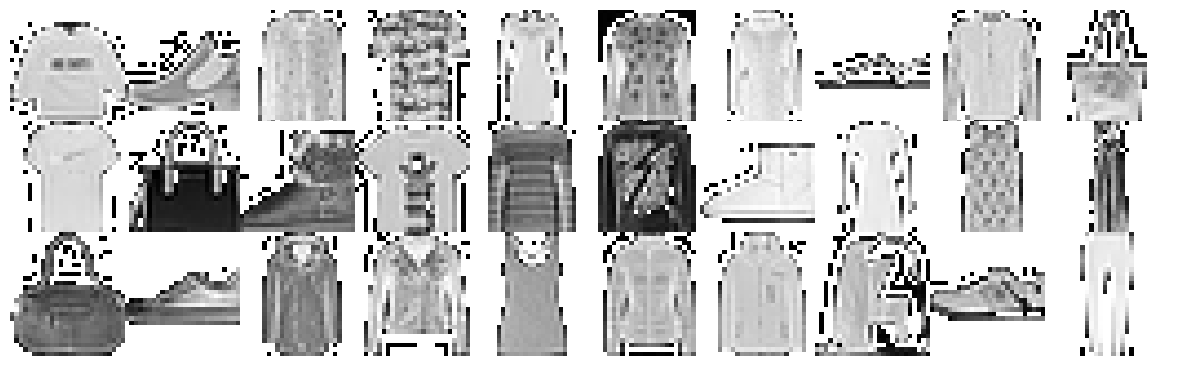

In [29]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(dataset[i][0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')/

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [39]:
import pytorch_lightning as pl

In [34]:
from torchvision.models import resnet18 ,ResNet18_Weights

In [35]:
res_model=resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [159]:
class LitResNet(pl.LightningModule):
    def __init__(self,model) -> None:
        super().__init__()
        self.model=model
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        input_in=self.model.fc.in_features
        self.model.fc=torch.nn.Linear(input_in,10)
        self.loss=torch.nn.CrossEntropyLoss()

    def forward(self,x):
      return self.model(x)

    def configure_optimizers(self):
        optimizer=torch.optim.Adam(self.model.fc.parameters(),lr=1e-3)
        return optimizer


    def training_step(self,batch,batchindex):
         x,y=batch
         yhat=self.model(x)
         loss=self.loss(yhat,y)
         self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
         return loss

    def validation_step(self,batch,batchindex):
         x,y=batch
         yhat=self.model(x)
         loss=self.loss(yhat,y)
         # Log the validation loss (automatically averaged across batches)
         self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

         return loss

    def predict_step(self,batch,batchindex=0):
       # Unpack the batch
       x,y=batch
       out=self.model(x)
       prob=torch.softmax(out,dim=1)
      #  prob=torch.max(prob,dim=1)
       pred=torch.argmax(out,axis=1)
       return {"prob":prob,"pred":pred}

In [160]:
model=LitResNet(res_model)
trainer=pl.Trainer(max_epochs=1,accelerator="gpu",devices=1)
trainer.fit(model,train_dataloaders=train_dls, val_dataloaders=val_dls)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ResNet           | 11.2 M | eval 
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
2   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 67 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [161]:
output=trainer.predict(model, train_dls)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [191]:
np.concat([[1,2],[3,4]])
np.ravel([[1,2],[3,4]])

array([1, 2, 3, 4])

array([1, 2, 3, 4])

In [151]:
from sklearn.metrics import roc_curve

In [152]:
roc_curve(y_train,pred_prob)

ValueError: multiclass format is not supported

In [153]:
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [113]:
pred = torch.cat(pred, dim=0)   # shape: (num_samples,)


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)


In [90]:
pred

tensor([8, 9, 4,  ..., 8, 8, 7])

In [91]:
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [96]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score

In [93]:
confusion_matrix(y_train,pred)

array([[3213,   89,  379,  721,  457,    6,  873,    0,  255,    7],
       [   7, 5572,   52,  287,   24,    4,   43,    0,   10,    1],
       [ 219,   30, 3556,  190, 1173,    4,  660,    0,  167,    1],
       [ 138,  564,  149, 4416,  350,   19,  291,    0,   72,    1],
       [ 163,   29,  815,  708, 3432,    3,  756,    1,   87,    6],
       [   5,    1,    0,    9,    0, 5091,    7,  542,   72,  273],
       [ 747,   77,  663,  538, 1183,   15, 2584,    1,  189,    3],
       [   0,    0,    0,    0,    0,  788,    0, 4704,   25,  483],
       [  82,   21,   40,   86,   30,  140,   73,   50, 5369,  109],
       [   5,    0,    0,   31,    1,  188,    6,  314,   79, 5376]])

In [94]:
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [95]:
accuracy_score(y_train,pred)

0.7218833333333333

In [97]:
recall_score(y_train,pred,average='macro')

0.7218833333333333

In [98]:
precision_score(y_train,pred,average='macro')

0.7199326419012014

In [154]:
from sklearn.preprocessing import label_binarize
classes= list(range(10))
y_train_bin = label_binarize(y_train, classes=classes)

In [156]:
y_train_bin.shape

(60000, 10)

In [157]:
y_train

array([2, 9, 6, ..., 8, 8, 7])

In [158]:
y_train_bin

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])